In [1]:
import numpy as np
import h5py,time, matplotlib.pyplot as plt
from scipy.optimize import fmin_cg
from drift.core import manager
import corrcal2
import sys
sys.path.insert(0,'/home/zahra/PIPELINE')
from log_red_cal_new import Visibilities_grid, Bls_counts, colour_scatterplot

I generate simulated visibility data that contains gains and noise. Below I have timestreams with different amounts of gain fluctuations. The 'ts_2' file is true visibilities without gains or noise, the 'ag_2' is visibilities with gains added, 'rg_2' is the gains that I input and 'gn_2' is the visibilities with noise and gains. 

In [2]:
#These files contain gains with .001 fluctuations
ts_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis/maps/tstream_2.h5','r')
ag_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis/rand_gains/amp_pt001_phase_pt001/app_gain_2.h5','r')
rg_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis/rand_gains/sig_pt0012.h5','r')
gn_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis/rand_gains/ts_final/app_gain_noise_2.h5','r')

'''
#These files contain gains with .01 fluctuations
ts_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt01_gain_fluc/maps/tstream_2.h5','r')
ag_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt01_gain_fluc/rand_gains/amp_pt01_phase_pt01/app_gain_2.h5','r')
rg_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt01_gain_fluc/rand_gains/sig_pt012.h5','r')
gn_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt01_gain_fluc/rand_gains/ts_final/app_gain_noise_2.h5','r')

#These files contain gains with .1 fluctuations
ts_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt1_gain_fluc/maps/tstream_2.h5','r')
ag_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt1_gain_fluc/rand_gains/amp_pt1_phase_pt1/app_gain_2.h5','r')
rg_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt1_gain_fluc/rand_gains/sig_pt12.h5','r')
gn_2=h5py.File('/home/zahra/PIPELINE/ex_3by3_kl/draco_synthesis_pt1_gain_fluc/rand_gains/ts_final/app_gain_noise_2.h5','r')
'''
#The config file used to generate the visibility timestreams using draco and driftscan-radiocosmology packages
m=manager.ProductManager.from_config('/home/zahra/PIPELINE/ex_3by3_kl/prod_params_custom.yaml')

Product directory: /home/zahra/PIPELINE/ex_3by3_kl/bt_matrices


In [3]:
time_channel=400 # We look at a single time channel
Ndish=9 #We are using a 3 by 3 array, and assuming one feed per dish

The 'log_red_cal_new' module is used to separate visibilities according to redundant blocks, as required for corrcal, and to manually add noise to the visibilities. 

(0.012207031977595827, 'sigma_gn')
(0.01, 'sigma')


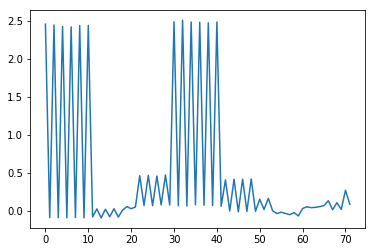

In [4]:
sigma=1.e-2
arr=Visibilities_grid(m,ts_2,rg_2,ag_2,gn_2,time_channel,sigma)
vis=arr[0][:,time_channel] #visibilities with noise

#sigma=arr[-2] #the amount of noise that we input 

#The visibilities has gains and noise and is separated according to redundant baselines
data=np.zeros(2*vis.size)
data[0::2]=vis.real #Here we separate the visibilites so that the array alternates real and imaginary values
data[1::2]=vis.imag
plt.plot(data)
plt.savefig('vis_sig_1e-2')
plt.show()

In [5]:
noiseless_vis=arr[1][:,time_channel]
print (np.cov(noiseless_vis[:6]))

(7.0091391621266805e-06+0j)


In [6]:
correlation_arr,sum_counts,corr_counts=Bls_counts(m)

I also have the following lims array, the diagonal matrix for the noise and zero point sources

In [7]:
lims=sum_counts 
print (lims,'lims') #There are 36 visibilities for the 3 by 3 array, so the cumulative sum of the lims is 36
diag=sigma**2*np.ones(2*vis.size)
src=np.zeros(2*vis.size)

(array([ 6,  9, 11, 15, 21, 25, 27, 28, 30, 33, 35, 36]), 'lims')


I use just the diagonals of the sky covariance matrix which is generated using the 21cm signal-using the driftscan package. 

In [8]:

klobj=m.kltransforms['kl']
sum_full_real=np.zeros((102,102))
for i in range(201):
    sum_full_real+=m.beamtransfer.project_matrix_sky_to_telescope(i,klobj.signal())[0,:,0,:].real
sum_full_imag=np.zeros((102,102))
for i in range(201):
    sum_full_imag+=m.beamtransfer.project_matrix_sky_to_telescope(i,klobj.signal())[0,:,0,:].imag
sum_real_diag=np.diag(sum_full_real)
sum_imag_diag=np.diag(sum_full_imag)
real_sig_condensed_1=sum_real_diag[3:51][0::4]
real_sig_condensed_2=sum_real_diag[54:102][0::4]

imag_sig_condensed_1=sum_imag_diag[3:51][0::4]
imag_sig_condensed_2=sum_real_diag[54:102][0::4]


real_signal_expanded_1=np.repeat(real_sig_condensed_1,corr_counts)
real_signal_expanded_2=np.repeat(real_sig_condensed_2,corr_counts)

imag_signal_expanded_1=np.repeat(imag_sig_condensed_1,corr_counts)
imag_signal_expanded_2=np.repeat(imag_sig_condensed_2,corr_counts)

real_signal=np.append(real_signal_expanded_1,real_signal_expanded_2)
imag_signal=np.append(imag_signal_expanded_1,imag_signal_expanded_2)

vecs=np.vstack([real_signal,imag_signal])
#vecs=np.load('sky_cov_mat_stacked_real_imaginary_shape_2by72.npy')


For the redundant case, I use the following, which Jon made mention of in corrcal and which he uses in an example. One thing I am quite confused by  

In [9]:
#vec_real=1000*np.load('vec_real.npy')
#vec_imag=1000*np.load('vec_imag.npy')
#vecs=np.array([vec_real,vec_imag])

v1=np.zeros(2*vis.size)
v1[0::2]=1
v2=np.zeros(2*vis.size)
v2[1::2]=1
vecs=1000*np.vstack([v1,v2])

In [10]:
mat=corrcal2.sparse_2level(diag,vecs,src,2*lims)

here


In [11]:
ant1=correlation_arr[:,0].astype(int)
ant2=correlation_arr[:,1].astype(int)
print (ant1,'ant1')
print (ant2,'ant2')

(array([0, 1, 3, 4, 6, 7, 0, 3, 6, 2, 5, 1, 2, 4, 5, 0, 1, 2, 3, 4, 5, 0,
       1, 3, 4, 0, 3, 2, 1, 2, 0, 1, 2, 0, 1, 0]), 'ant1')
(array([1, 2, 4, 5, 7, 8, 2, 5, 8, 3, 6, 3, 4, 6, 7, 3, 4, 5, 6, 7, 8, 4,
       5, 7, 8, 5, 8, 6, 6, 7, 6, 7, 8, 7, 8, 8]), 'ant2')


Simulated gains are separated so that they alternate between real and imaginary for all the dishes

In [12]:
gain=rg_2['gain'][0,:Ndish,time_channel]
sim_gains=np.append(gain.real,gain.imag)

sim_gains=np.zeros(Ndish*2)
sim_gains[0::2]=gain.real
sim_gains[1::2]=gain.imag


At the moment I am trying a single random input gain that introduces a 10% random offset from the actual simulated gains and I do 100 000 runs with the same input gains and same visibility noise. 

In [13]:
'''
gvec=np.array([])
for i in range(len(sim_gains)):
    gvec=np.append(gvec,np.random.normal(0,.01,2*Ndish)[i]+sim_gains[i])
'''

random=np.random.normal(0,.0001,2*Ndish)

gvec=np.array([])
for i in range(len(sim_gains)):
    gvec=np.append(gvec,random[i]+sim_gains[i])


runs=1
'''
runs=1
gvec=np.zeros((runs,2*Ndish))
for j in range(runs):
    for i in range(len(sim_gains)):
        gvec[j,i]=np.random.normal(0,.1,2*Ndish)[i]+sim_gains[i]
#gvec=np.append(rand_gains.real,rand_gains.imag)
'''

fit_gains=np.zeros((runs,Ndish*2))

#args=(data,mat,ant1,ant2)
#x=np.linspace(-.98,1.2,18)
#print (corrcal2.get_chisq(gvec,*args),'chi sq of x')


for init_run in range(runs):
    niter=1000;
    fac=1.e9;
    normfac=1.e-8
    asdf=fmin_cg(corrcal2.get_chisq,gvec*fac,corrcal2.get_gradient,(data,mat,ant1,ant2,fac,normfac))
    fit_gains[init_run,:]=asdf/fac
    abs_full=np.array([])
    for i in range(2*Ndish):
        if i%2==0:
            abs_full=np.append(abs_full,np.abs(np.complex(sim_gains[i],sim_gains[1+i]))) #have no idea what abs value gain to divide by,
                                                                                        #could be absolute fit gains
    #fit_gains[m,:]=fit_gains[m,:]/(np.mean(abs_full))

            #print (np.complex(fit_gains[m,i],fit_gains[m,1+i]),'comp fit gains')
    #for i in range(Ndish):
        #fit_gains[m,:]=fit_gains[m,:]/(np.mean(np.abs(np.complex(fit_gains[m,i],fit_gains[m,9+i]))))

#np.save('fit_gains_4.npy',fit_gains)


here
here
[ 2.45346602e+04 -9.31722253e+02  2.44249970e+04 -9.30816557e+02
  2.42344501e+04 -9.41515928e+02  2.41821561e+04 -8.96012987e+02
  2.43541810e+04 -9.54765070e+02  2.43773566e+04 -8.30667444e+02
  2.15023751e+00 -8.51775056e+01 -3.68923398e+01  6.34730755e+01
  3.48117504e+01  2.17228899e+01 -9.45808436e+01  2.31507418e+01
  9.47543361e+01 -2.31567918e+01 -3.13637550e+01 -3.52365058e+01
  1.93730943e+01 -4.57574413e+01 -6.32071041e+01  4.63302480e+01
  7.50809190e+01  3.46982440e+01 -2.52483513e+01 -2.25831766e+01
  2.36075142e+02 -2.09068446e+01 -2.58040258e+01  1.17874496e+02
 -7.08427762e+01  4.77663282e+01 -1.06516643e+02 -4.10079393e+01
 -7.39622234e+00 -8.16397039e+01 -7.18197934e+01  5.34159632e+01
  5.09119483e+00 -5.03917105e+01  2.02693926e+01 -8.86924611e+00
  4.65630495e+01  5.95411853e+00 -5.95764732e+01  8.32234851e+01
  5.95427447e+01 -8.32187469e+01 -3.77917974e-08 -1.99352712e-08
 -5.93315746e+01  7.87406284e+01  5.93085614e+01 -7.86728225e+01
 -1.16661895e+0

I then take the average and stnd deviation of these runs 

In [14]:
gain_std=(np.std(fit_gains,axis=0)/np.sqrt(runs)).flatten()
gain_mean=np.mean(fit_gains,axis=0).flatten()

#print (gvec.flatten()[0::2],'sim gains with fluctuation')
#print (fit_gains.flatten()[0::2],'fit gains')
print (gain_mean[0::2],'gain mean')
print (sim_gains[0::2],'sim gains')
print (np.abs(gain_mean[0::2]-sim_gains[0::2]).min(),np.abs(gain_mean[0::2]-sim_gains[0::2]).max(),'diff gains')
print (gain_std[0::2], 'std dev for fit gains')

sim_gains_amp=sim_gains[0::2]
rec_gains_amp=gain_mean[0::2]
sim_gains_phase=sim_gains[1::2]
rec_gains_phase=gain_mean[1::2]
gain_std_amp=gain_std[0::2]
gain_std_phase=gain_std[1::2]

rel_err=np.abs(rec_gains_amp-sim_gains_amp)/sim_gains_amp
print (rel_err)

#np.save('gain_mean_sig_1e-2_run2',gain_mean)

#sim_gains_amp=sim_gains[:Ndish]
#rec_gains_amp=gain_mean[:Ndish]
#sim_gains_phase=sim_gains[Ndish:]
#rec_gains_phase=gain_mean[Ndish:]
#gain_std_amp=gain_std[:Ndish]
#gain_std_phase=gain_std[Ndish:]

'''
fig, ax = plt.subplots()

lims = [-1.5,  # min of both axes
    1+np.max([ax.get_xlim()]),  # max of both axes
]
ax.scatter(sim_gains_amp,rec_gains_amp)
plt.errorbar(sim_gains_amp,rec_gains_amp,xerr=None,yerr=gain_std_amp,linestyle="None")

ax.plot(lims, lims,'g')
#plt.errorbar(x_sim[:Ndish,time_channel],x_rec[:Ndish,time_channel],xerr=None,yerr=error_single[:Ndish],linestyle="None")
plt.xlabel('Simulated gains')
plt.ylabel('Recovered gains')
#plt.ylim(.95,1.05)
#plt.xlim(.95,1.05)

plt.show()
'''

(array([1.00088192, 0.99991343, 1.00085685, 1.00134983, 0.99984235,
       1.00033973, 1.00012296, 0.9998677 , 1.0001027 ]), 'gain mean')
(array([1.00084956, 0.99994372, 1.00093686, 1.00152207, 0.99980777,
       1.00021132, 1.00005068, 1.00004054, 1.0001519 ]), 'sim gains')
(3.0286626901632197e-05, 0.00017283693061243, 'diff gains')
(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'std dev for fit gains')
[3.23300057e-05 3.02883316e-05 7.99387256e-05 1.71974864e-04
 3.45878977e-05 1.28382285e-04 7.22758735e-05 1.72829924e-04
 4.91862088e-05]


'\nfig, ax = plt.subplots()\n\nlims = [-1.5,  # min of both axes\n    1+np.max([ax.get_xlim()]),  # max of both axes\n]\nax.scatter(sim_gains_amp,rec_gains_amp)\nplt.errorbar(sim_gains_amp,rec_gains_amp,xerr=None,yerr=gain_std_amp,linestyle="None")\n\nax.plot(lims, lims,\'g\')\n#plt.errorbar(x_sim[:Ndish,time_channel],x_rec[:Ndish,time_channel],xerr=None,yerr=error_single[:Ndish],linestyle="None")\nplt.xlabel(\'Simulated gains\')\nplt.ylabel(\'Recovered gains\')\n#plt.ylim(.95,1.05)\n#plt.xlim(.95,1.05)\n\nplt.show()\n'

I repeat the 100 000 runs and take the average. I then plot the difference between these two averages to see if the fit gains converge at all. They do not converge

This is the difference plot for noise with $\sigma=10^{2}$

[1.05337478 0.94250463 1.06755711 0.88323424 1.18896368 0.99078756
 0.83157457 0.98460011 0.88327471]
[ 0.0046572  -0.02045007 -0.0137996   0.0069106  -0.00298314 -0.00978437
  0.01069458  0.00173487  0.00630581]


Text(0.5,0,'Antenna index')

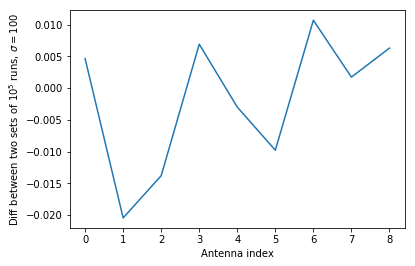

In [15]:
run_1_amp_sig2=np.load('gain_mean.npy')[0::2]
run_2_amp_sig2=np.load('gain_mean_2.npy')[0::2]
print (run_1_amp_sig2)
diff_two_runs_sig2=run_1_amp_sig2-run_2_amp_sig2
print (diff_two_runs_sig2)
plt.plot(diff_two_runs_sig2)
plt.ylabel('Diff between two sets of $10^5$ runs, $\sigma=100$')
plt.xlabel('Antenna index')

This is the difference plot for noise with $\sigma=10^{-2}$

[1.05496156 0.95981539 1.08325058 0.8673293  1.18731443 1.01300692
 0.81597279 0.99444607 0.86974343]
[-0.00061709  0.01118198  0.02991821  0.00165967 -0.02082058  0.01029009
  0.00206314  0.00791487 -0.01955878]


Text(0.5,0,'Antenna index')

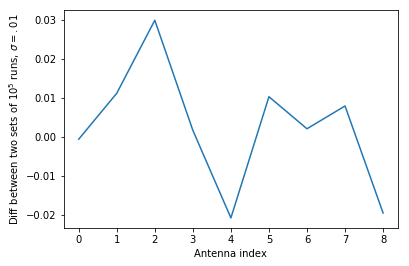

In [16]:
run_1_amp_sigpt01=np.load('gain_mean_sig_1e-2.npy')[0::2]
run_2_amp_sigpt01=np.load('gain_mean_sig_1e-2_run2.npy')[0::2]
print (run_1_amp_sigpt01)
diff_two_runs_sigpt01=run_1_amp_sigpt01-run_2_amp_sigpt01
print (diff_two_runs_sigpt01)
plt.plot(diff_two_runs_sigpt01)
plt.ylabel('Diff between two sets of $10^5$ runs, $\sigma=.01$')
plt.xlabel('Antenna index')

If the results did converge for many runs, I would be able to see if noise affected the scatter of the fit gains vs simulated gains-that was the plan